# Overview

In this notebook, we demonstrate how we train models with our additive-Gaussian-noise-augmented images, and test these models on the original datasets, as outlined in our paper "Generalization Across Experimental Parameters in Machine Learning Analysis of High Resolution Transmission Electron Microscopy Datasets". To actually run this notebook, you need to have downloaded and/or created the preprocessed datasets (described more in the dataset_creation folder and can be downloaded at https://doi.org/10.7941/D1SP93).

The general idea here is to take a model trained on the higher dosage data (884e/A2 and 423e/A2) and then see how much we can improve performance on lower dosage datasets (423e/A2 and 80e/A2) by augmenting the training set with noise.

# Import Packages

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import h5py
import numpy as np
import matplotlib.pyplot as plt
import time
from pandas import DataFrame
import pandas as pd
from routines import *
from skimage import io, transform
import csv
import copy

# Routines

We're going to add noise during training by augmenting the training images when called. Below, we've modified our Dataset object to have an additional parameter, noise_rho, which adds additive Gaussian noise centered at 0 with a standard deviation of noise_rho. Note that we also need to rescale our noise-augmented images such that their standard deviation is still around 1.

In [2]:
class TEMImageDataset_Local_PartialRot_Noise(Dataset):
  """Creates a Dataset object that takes in a h5 file with all the training images"""

  def __init__(self, image_dataset, labels_dataset, transform_flag = False, noise_rho = 0):
    """ Args:
      image_filepath (string): path to the h5 file with the images
      img_key (string): the "key" for the images in the h5 file
      labels_filepath (string): path to the h5 file with the maps/labels
      lbl_key (string): the "key" for the labels in the h5 file
      transform (Boolean): whether or not to randomly transform the dataset
    """
    self.image = image_dataset
    self.labels = labels_dataset
    self.transform_flag = transform_flag
    self.noise_rho = noise_rho
  
  def __len__(self):
    return self.image.shape[0]
  
  def __getitem__(self, idx):
    #If the provided idx is a tensor, then convert it to a list
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    images = self.image[idx] #Note that these output np arrays, not tensors
    labels = self.labels[idx]
    
    # Add noise before transforming
    img_size = images.shape[1] # Assume square images
    images = np.float32((images+np.random.normal(scale=self.noise_rho,size=(1,img_size,img_size)))/np.sqrt(1+self.noise_rho**2)) #Make sure added noise is also float32
    
    if self.transform_flag:
        rot_or_not = torch.rand(1).numpy()
        #Rotate ~50% of the images
        if rot_or_not > 0.5:
            #Determine median bkgd value
            bkgd_val = np.median(images[labels==0])
        
            #Randomly flip and rotate
            rand_vals = torch.rand(2).numpy()
            if rand_vals[0] < 0.33:
                images[0,:,:] = np.flipud(images[0,:,:])
                labels[0,:,:] = np.flipud(labels[0,:,:])
            elif rand_vals[0] < 0.66:
                images[0,:,:] = np.fliplr(images[0,:,:])
                labels[0,:,:] = np.fliplr(labels[0,:,:])
            
            images[0,:,:] = transform.rotate(images[0,:,:],rand_vals[1]*360,mode='constant',cval=bkgd_val)
            labels[0,:,:] = transform.rotate(labels[0,:,:],rand_vals[1]*360,mode='constant',cval=0)
    sample = {'image': images, 'label': labels}
    
    return sample

We'll also use many of the routines designed for training/testing our UNet models, as described in our other notebook on model training/testing.

In [3]:
class TEMImageDataset_Local_PartialRot(Dataset):
  """Creates a Dataset object that takes in numpy arrays of the images and labels, and when querying for an image, augments ~50% of them by random rotation"""

  def __init__(self, image_dataset, labels_dataset, transform_flag = False):
    """ Args:
      image_dataset (array): NxHxW numpy array of the images
      labels_dataset (array): NxHxW numpy array of the labels
      transform (Boolean): whether or not to randomly transform ~half of the dataset
    """
    self.image = image_dataset
    self.labels = labels_dataset
    self.transform_flag = transform_flag
  
  def __len__(self):
    return self.image.shape[0]
  
  def __getitem__(self, idx):
    #If the provided idx is a tensor, then convert it to a list
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    images = self.image[idx] #Note that these output np arrays, not tensors
    labels = self.labels[idx]
    
    if self.transform_flag:
        rot_or_not = torch.rand(1).numpy()
        #Rotate ~50% of the images
        if rot_or_not > 0.5:
            #Determine median bkgd value
            bkgd_val = np.median(images[labels==0])
        
            #Randomly flip and rotate
            rand_vals = torch.rand(2).numpy()
            if rand_vals[0] < 0.33:
                images[0,:,:] = np.flipud(images[0,:,:])
                labels[0,:,:] = np.flipud(labels[0,:,:])
            elif rand_vals[0] < 0.66:
                images[0,:,:] = np.fliplr(images[0,:,:])
                labels[0,:,:] = np.fliplr(labels[0,:,:])
            
            images[0,:,:] = transform.rotate(images[0,:,:],rand_vals[1]*360,mode='constant',cval=bkgd_val)
            labels[0,:,:] = transform.rotate(labels[0,:,:],rand_vals[1]*360,mode='constant',cval=0)
    sample = {'image': images, 'label': labels}
    
    return sample

#Model classes
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size1, kernel_size2):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size1, padding=(kernel_size1-1)//2)
    self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size2, padding=(kernel_size2-1)//2)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu1 = nn.ReLU()
    self.relu2 = nn.ReLU()
    self.conv_add = nn.Conv2d(in_channels,out_channels,kernel_size = 1) #Expands/contracts input image in the filter dimension for the ReLU skip connection

    #Copied from torchvision to correctly initialize layers
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
  
  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu1(out)
    out = self.conv2(out)
    out = self.bn2(out)
    skip = self.conv_add(x)
    out += skip
    out = self.relu2(out)
    return out

class UNet(nn.Module): #Adapted from Erin's code
  def __init__(self, num_blocks,filter_sequence,max_pool_sequence, num_classes = 2):
    #num_blocks: number of residual blocks in network
    #filter_sequence: list of filter sizes
    #kernel_num: the number of kernels that are of size 3
   
    super(UNet, self).__init__()
    self.downs = nn.ModuleList()
    self.ups = nn.ModuleList()
   
    self.pools = nn.ModuleList()
    self.upsamples = nn.ModuleList()
    

    # creates down and pooling layers
    in_channels = 1
    for i in range(num_blocks):
        self.downs.append(ResidualBlock(in_channels,filter_sequence[i],3,3))
        in_channels = filter_sequence[i]
        self.pools.append(nn.MaxPool2d(kernel_size = max_pool_sequence[i], stride = max_pool_sequence[i]))



    # creates up and upsampling layers
    for i in reversed(range(num_blocks)):
        self.ups.append(ResidualBlock(filter_sequence[i]+filter_sequence[i+1],filter_sequence[i],3,3)) #The 2*filters in the input channels refers to the extra channels from the concat layer
        self.upsamples.append(nn.Upsample(scale_factor=max_pool_sequence[i]))

    # "bottleneck" or middle part at bottom of U
    self.bottleneck = ResidualBlock(filter_sequence[num_blocks-1],filter_sequence[num_blocks],3,3)

    # final convolution with 1x1 kernel
    self.final_conv = nn.Conv2d(filter_sequence[0], num_classes, kernel_size = 1)

    self.num_blocks = num_blocks

  
  def forward(self, x):
  
    skips = [] # empty array to store skip connections

    for i in range(self.num_blocks):
        x = self.downs[i](x)
        skips.append(x)
        x = self.pools[i](x)

    x = self.bottleneck(x)
    skips = skips[::-1] # reverse skips array because we want to work with latest one first

    for idx in range(self.num_blocks):
      x = self.upsamples[idx](x)
      skip = skips[idx]
      concat_skip = torch.cat((skip,x),dim=1)
      x = self.ups[idx](concat_skip)

    out = self.final_conv(x)

    return out

#Training definitions
def train_loop(dataloader, model, loss_fn, optimizer, device):
  avg_loss = 0
  dice_score = 0
  hard_dice = 0
  size = len(dataloader.dataset)
  model.train()
  for batch_i, sample_batch in enumerate(dataloader):
    #Move the images and labels to the GPU
    images = sample_batch['image'].to(device)
    labels = sample_batch['label'].type(torch.LongTensor).to(device)

    #Compute the prediction (i.e. forward pass)
    pred = model(images)
    
    #Compute the loss
    loss = loss_fn(pred,labels[:,0,:,:]) #can't have dimensions in the channel index

    #Backpropagation
    #First, reset the gradients of the model parameters
    optimizer.zero_grad()
    #Back prop the prediction loss
    loss.backward()
    #Adjust the parameters using the gradients collected
    optimizer.step()

    #Log the loss and dice score
    avg_loss += loss.item()*sample_batch['image'].shape[0] #Undo the normalization by mini-batch size
    dice_score += compute_dice(pred, labels, device).item()
    hard_dice += compute_dice_hard(pred, labels, device).item()

  #After going through all the batches, compute the average loss and dice score
  return avg_loss/size, dice_score/size, hard_dice/size

def test_loop(dataloader, model, loss_fn, optimizer, device):
  avg_loss = 0
  dice_score = 0
  hard_dice = 0
  size = len(dataloader.dataset)
  model.eval()
  with torch.no_grad():
    for batch_i, sample_batch in enumerate(dataloader):
      #Move the images and labels to the GPU
      images = sample_batch['image'].to(device)
      labels = sample_batch['label'].type(torch.LongTensor).to(device)
      #Compute the prediction (i.e. forward pass)
      pred = model(images)
      #Compute the loss
      loss = loss_fn(pred,labels[:,0,:,:]) 
      #Log the loss and dice score
      avg_loss += loss.item()*sample_batch['image'].shape[0] #Undo the normalization by mini-batch size
      dice_score += compute_dice(pred, labels, device).item()
      hard_dice += compute_dice_hard(pred, labels, device).item()

  #After going through all the batches, compute the average loss and dice score
  return avg_loss/size, dice_score/size, hard_dice/size


def compute_dice(y_pred, y_truth, device1, smooth=1):
  #Need to first convert the ground truth into one-hot labels
  #Create a new one_hot tensor on the device
  one_hot = torch.zeros_like(y_pred, device=device1)
  one_hot.scatter_(1,y_truth,1) #first argument is dimension that needs to "expand", second is the indicies to go to, third is the value to place at those locations
  sm_layer = nn.Softmax2d()
  y_pred = sm_layer(y_pred) #normalize the class score
  intersection = torch.sum(y_pred[:,1,:,:] * one_hot[:,1,:,:], dim=(1,2)) #elemental multiplication and then sum, but only for one of the predictions, gives a N-sized tensor
  return torch.sum(torch.div(2. * intersection + smooth , torch.sum(one_hot[:,1,:,:], dim=(1,2)) + torch.sum(y_pred[:,1,:,:],dim=(1,2)) + smooth))

def compute_dice_hard(y_pred, y_truth, device1, smooth=1):
  #Need to first convert the ground truth into one-hot labels
  #Create a new one_hot tensor on the device
  one_hot = torch.zeros_like(y_pred, device=device1)
  one_hot.scatter_(1,y_truth,1) #first argument is dimension that needs to "expand", second is the indicies to go to, third is the value to place at those locations
  sm_layer = nn.Softmax2d()
  y_pred = torch.round(sm_layer(y_pred)) #normalize the class score
  intersection = torch.sum(y_pred[:,1,:,:] * one_hot[:,1,:,:], dim=(1,2)) #elemental multiplication and then sum, but only for one of the predictions, gives a N-sized tensor
  return torch.sum(torch.div(2. * intersection + smooth , torch.sum(one_hot[:,1,:,:], dim=(1,2)) + torch.sum(y_pred[:,1,:,:],dim=(1,2)) + smooth))

def test_model(model, test_imgs, test_lbls, device, b_size, loss_fn, optimizer):
    test_dataset = TEMImageDataset_Local_PartialRot(test_imgs,test_lbls, transform_flag = False)
    test_dataloader = DataLoader(test_dataset, batch_size=b_size, shuffle=True, num_workers=2)
    #Run through model
    test_loss, test_dice, test_hard_dice = test_loop(test_dataloader, model, loss_fn, optimizer, device)
    return test_loss, test_dice, test_hard_dice

def shuffle_Aug_PyTorch(imgs, lbls, seed):
    #Expand dimensions
    img_dataset = np.expand_dims(imgs, axis=3)
    lbl_dataset = np.expand_dims(lbls, axis=3)
    
    #Shuffle and PyTorch format
    img_dataset, lbl_dataset = dihedral_augmentation(img_dataset,lbl_dataset)
    img_dataset, lbl_dataset = shuffle_dataset(img_dataset, lbl_dataset, seed)
    img_dataset = pyTorch_format(img_dataset)
    lbl_dataset = pyTorch_format(lbl_dataset)
    
    return img_dataset, lbl_dataset

# Training models with the noise-augmented dataset

First, let's grab the high-dosage dataset.

In [55]:
img_filepath = 'Datasets/Flatfield corrected/Au_5nm_330kx_884e_Std_UTC_FFCorr_Team05_Images.h5'
label_filepath = 'Datasets/Flatfield corrected/Au_5nm_330kx_884e_Std_UTC_FFCorr_Team05_Labels.h5'
img_dataset = h5py.File(img_filepath,'r')['images'][:,:,:]
label_dataset = h5py.File(label_filepath,'r')['labels'][:,:,:]

Next, we'll train a series of models where the training set has been augmented with additive noise with rho standard deviation. Since we want to examine the change in performance from only the change in noise characteristics of the training set, we want to keep the training patches, validation patches, and model initial conditions the same. We'll choose to compare against the model that held out the 0th fold as the test set, which uses the seed=962 to set its initial conditions. 

In [5]:
# Split into training and validation sets

k_folds = 5

#Split the dataset and labels into k sub-arrays

imgs_folds = np.array_split(img_dataset, k_folds)
lbls_folds = np.array_split(label_dataset, k_folds)
fold_size = img_dataset.shape[0]//k_folds

i=0
test_dataset = imgs_folds.pop(i)
test_lbls = lbls_folds.pop(i)
train_dataset = np.concatenate(imgs_folds)
train_lbls = np.concatenate(lbls_folds)

valid_set_size = int(12.5*train_dataset.shape[0]//100)
valid_dataset = train_dataset[i*fold_size:(i*fold_size+valid_set_size),:,:]
valid_lbls = train_lbls[i*fold_size:(i*fold_size+valid_set_size),:,:]
train_dataset = np.concatenate((train_dataset[:i*fold_size,:,:],train_dataset[(i*fold_size+valid_set_size):,:,:]))
train_lbls = np.concatenate((train_lbls[:i*fold_size,:,:],train_lbls[(i*fold_size+valid_set_size):,:,:]))

# Augment and shuffle
train_dataset, train_lbls = shuffle_Aug_PyTorch(train_dataset, train_lbls,9201)
valid_dataset, valid_lbls = shuffle_Aug_PyTorch(valid_dataset, valid_lbls,6274)

In [10]:
learning_rate = 1e-4
b_size = 32
epochs = 250

#Specify model parameters
num_blocks = 4
filter_sequence = [4,8,16,32,64,128,256,512]
pool_sequence = [2,2,2,2]
rhos = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5]
# rhos = [0.125, 0.375,0.625, 0.875, 1.125] # I later came back and added more data points at the lower noise levels
for rho in rhos:
    print ('\n Rho: ', str(rho))
    # Create datasets
    train_dataset_obj = TEMImageDataset_Local_PartialRot_Noise(train_dataset,train_lbls, transform_flag = True, noise_rho = rho)
    valid_dataset_obj = TEMImageDataset_Local_PartialRot_Noise(valid_dataset,valid_lbls, transform_flag = False, noise_rho = rho)
    
    seed_num = 962
    torch.manual_seed(seed_num)
    
    #Setup the data loader
    train_dataloader = DataLoader(train_dataset_obj, batch_size=b_size, shuffle=True, num_workers=4)
    valid_dataloader = DataLoader(valid_dataset_obj, batch_size=b_size, shuffle=True, num_workers=4)

    model = UNet(num_blocks,filter_sequence,pool_sequence)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

    #Setup GPU and move model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    #Set the logging variables
    history = {'loss': [], 'dice_coef': [], 'hard_dice_coef': [], 'val_loss': [], 'val_dice_coef': [], 'val_hard_dice_coef': [], 'time': [], 'recorded_epoch': []}
    
    #Run the training
    best_loss = 1000
    for t in range(epochs):
        start_time=time.time()
        avg_loss, avg_dice, avg_hard_dice = train_loop(train_dataloader, model, loss_fn, optimizer, device)
        history['loss'].append(avg_loss)
        history['dice_coef'].append(avg_dice)
        history['hard_dice_coef'].append(avg_hard_dice)
        val_loss, val_dice, val_hard_dice = test_loop(valid_dataloader, model, loss_fn, optimizer, device)
        history['val_loss'].append(val_loss)
        history['val_dice_coef'].append(val_dice)
        history['val_hard_dice_coef'].append(val_hard_dice)  
        end_time = time.time()
        history['time'].append(end_time-start_time)
        # Record weights if this is the best model so far
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict()) #Needs to be a copy, otherwise it's just a pointer
            recorded_epoch = t
        history['recorded_epoch'].append(recorded_epoch)
        print('Rho: '+str(rho)+ ' Epoch: '+ str(t) + ' Val Dice: '+str(val_dice) + ' Recorded Epoch: '+str(recorded_epoch)+ ' Time: '+str(end_time-start_time), end='\r')

    
    rho_name = str(rho).replace('.','p')
    model.load_state_dict(best_model_state)
    torch.save(model,'Noise models/FF corrected 884/UNet_5nmAu330kX884eUTC_fold0_seed962_rho'+str(rho_name)+'_model.h5')
    history_dataframe = DataFrame(history)
    hist_filename = 'Noise models/FF corrected 884/UNet_5nmAu330kX884eUTC_fold0_seed962_rho'+str(rho_name)+'_trainingLossHistory.csv'
    with open(hist_filename, mode='w') as f:
        history_dataframe.to_csv(f)


 Rho:  0.25
Rho: 0.25 Epoch: 249 Val Dice: 0.9066730075412326 Recorded Epoch: 226 Time: 7.0057570934295654
 Rho:  0.5
Rho: 0.5 Epoch: 249 Val Dice: 0.8999575906329684 Recorded Epoch: 244 Time: 7.8605535030364996
 Rho:  0.75
Rho: 0.75 Epoch: 249 Val Dice: 0.8994579315185547 Recorded Epoch: 244 Time: 6.9827561378479045
 Rho:  1
Rho: 1 Epoch: 249 Val Dice: 0.8999105824364556 Recorded Epoch: 235 Time: 7.0048971176147465
 Rho:  1.25
Rho: 1.25 Epoch: 249 Val Dice: 0.8977181381649442 Recorded Epoch: 247 Time: 6.9956023693084725
 Rho:  1.5
Rho: 1.5 Epoch: 249 Val Dice: 0.8965994517008463 Recorded Epoch: 244 Time: 7.0341143608093265
 Rho:  1.75
Rho: 1.75 Epoch: 249 Val Dice: 0.8930446174409654 Recorded Epoch: 244 Time: 7.0523946285247885
 Rho:  2
Rho: 2 Epoch: 249 Val Dice: 0.887822323375278 Recorded Epoch: 244 Time: 7.02827858924865746
 Rho:  2.25
Rho: 2.25 Epoch: 249 Val Dice: 0.8839141792721219 Recorded Epoch: 249 Time: 7.0730221271514895
 Rho:  2.5


# Test performance on the low, medium, and high dosage datasets

First, we'll test on the low dosage dataset:

In [53]:
# Import LD dataset
img_filepath = 'Datasets/Flatfield corrected/Au_5nm_330kx_80e_Std_UTC_FFCorr_Team05_Images.h5'
label_filepath = 'Datasets/Flatfield corrected/Au_5nm_330kx_80e_Std_UTC_FFCorr_Team05_Labels.h5'
img_ld_dataset = h5py.File(img_filepath,'r')['images'][:,:,:]
label_ld_dataset = h5py.File(label_filepath,'r')['labels'][:,:,:]

The values that we are appending to our results are our results from when we trained the high dosage model (using this specific training set fold) and tested on the low dosage dataset.

In [54]:
test_dataset, test_lbls = shuffle_Aug_PyTorch(img_ld_dataset, label_ld_dataset, 7427)
rho_list = [0.125, 0.25, 0.375, 0.5, 0.625, 0.75,  0.875, 1,  1.125, 1.25, 1.5, 1.75, 2, 2.25, 2.5]
ld_results = {'rho': [], 'test_loss': [], 'test_dice': [], 'test_hard_dice': []}
ld_results['rho'].append(0)
ld_results['test_hard_dice'].append(0.464409418293995)
ld_results['test_loss'].append(0.936465563738875)
ld_results['test_dice'].append(0.478069625464566)

for rho in rho_list:
    rho_name = str(rho).replace('.','p')
    model_filepath = 'Noise models/FF corrected 884/UNet_5nmAu330kX884eUTC_fold0_seed962_rho'+rho_name+'_model.h5'
    model = torch.load(model_filepath)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    b_size = 32
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = 1e-4)
        
    # Run test set through model
    test_loss, test_dice, test_hard_dice = test_model(model, test_dataset, test_lbls, device, b_size, loss_fn, optimizer)
        
    # Record values
    ld_results['rho'].append(rho)
    ld_results['test_loss'].append(test_loss)
    ld_results['test_dice'].append(test_dice)
    ld_results['test_hard_dice'].append(test_hard_dice)

When plotting out our results, we add a horizontal line to show us the average performance of a model trained on the low dosage dataset and tested on the low dosage data, giving an idea as to the "expected" performance when testing on data similar to the training set.

(0.3, 0.9)

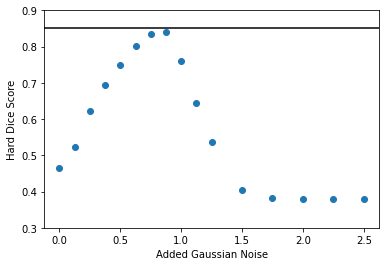

In [93]:
plt.scatter(ld_results['rho'],ld_results['test_hard_dice'])
plt.axhline(y=0.852,color='k')
plt.xlabel('Added Gaussian Noise')
plt.ylabel('Hard Dice Score')
plt.ylim([0.3,0.9])

We'll then repeat for the medium dosage dataset:

In [54]:
img_filepath = 'Datasets/Au_5nm_330kx_423e_UTC_Team05_Std_Sess0821FFCorr_Images.h5'
label_filepath = 'Datasets/Au_5nm_330kx_423e_UTC_Team05_Std_Sess0821FFCorr_Labels.h5'
img_md_dataset = h5py.File(img_filepath,'r')['images'][:,:,:]
label_md_dataset = h5py.File(label_filepath,'r')['labels'][:,:,:]

In [55]:
test_dataset, test_lbls = shuffle_Aug_PyTorch(img_md_dataset, label_md_dataset, 7427)
rho_list = [0.125, 0.25, 0.375, 0.5, 0.625, 0.75,  0.875, 1,  1.125, 1.25, 1.5, 1.75, 2, 2.25, 2.5]
md_results = {'rho': [], 'test_loss': [], 'test_dice': [], 'test_hard_dice': []}
md_results['rho'].append(0)
md_results['test_hard_dice'].append(0.865177033636807)
md_results['test_loss'].append(0.121726199913929)
md_results['test_dice'].append(0.856245419425422)

for rho in rho_list:
    rho_name = str(rho).replace('.','p')
    model_filepath = 'Noise models/FF corrected 884/UNet_5nmAu330kX884eUTC_fold0_seed962_rho'+rho_name+'_model.h5'
    model = torch.load(model_filepath)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    b_size = 32
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = 1e-4)
        
    # Run test set through model
    test_loss, test_dice, test_hard_dice = test_model(model, test_dataset, test_lbls, device, b_size, loss_fn, optimizer)
        
    # Record values
    md_results['rho'].append(rho)
    md_results['test_loss'].append(test_loss)
    md_results['test_dice'].append(test_dice)
    md_results['test_hard_dice'].append(test_hard_dice)

(0.3, 0.95)

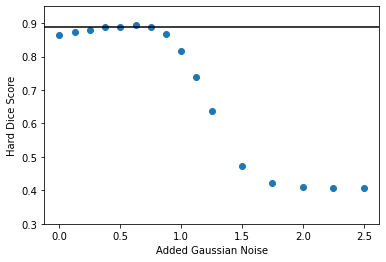

In [104]:
plt.scatter(md_results['rho'],md_results['test_hard_dice'])
plt.axhline(y=0.889,color='k')
plt.xlabel('Added Gaussian Noise')
plt.ylabel('Hard Dice Score')
plt.ylim([0.3,0.95])

And finally, we'll test on the original high dosage data. Note that we test on the entire high dosage dataset - not just the held out test set. Since we only feed noise-augmented patches during training, all the images are technically "new" to the network, and this also gives us a sense of how much noise augmentation starts making a dataset "different".

In [56]:
test_dataset, test_lbls = shuffle_Aug_PyTorch(img_dataset, label_dataset, 7427)
rho_list = [0.125, 0.25, 0.375, 0.5, 0.625, 0.75,  0.875, 1,  1.125, 1.25, 1.5, 1.75, 2, 2.25, 2.5]
hd_results = {'rho': [], 'test_loss': [], 'test_dice': [], 'test_hard_dice': []}
hd_results['rho'].append(0)
hd_results['test_hard_dice'].append(0.922700440561449)
hd_results['test_loss'].append(0.035549730666586)
hd_results['test_dice'].append(0.910678518785013)

for rho in rho_list:
    rho_name = str(rho).replace('.','p')
    model_filepath = 'Noise models/FF corrected 884/UNet_5nmAu330kX884eUTC_fold0_seed962_rho'+rho_name+'_model.h5'
    model = torch.load(model_filepath)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    b_size = 32
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = 1e-4)
        
    # Run test set through model
    test_loss, test_dice, test_hard_dice = test_model(model, test_dataset, test_lbls, device, b_size, loss_fn, optimizer)
        
    # Record values
    hd_results['rho'].append(rho)
    hd_results['test_loss'].append(test_loss)
    hd_results['test_dice'].append(test_dice)
    hd_results['test_hard_dice'].append(test_hard_dice)

And we can now plot out all of the results:

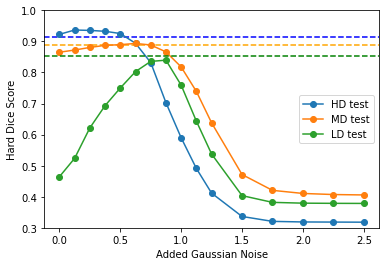

In [62]:
plt.axhline(y=0.915,color='b',linestyle='--')
plt.plot(hd_results['rho'],hd_results['test_hard_dice'], marker='o', label='HD test')
plt.axhline(y=0.889,color='orange',linestyle='--')
plt.plot(md_results['rho'],md_results['test_hard_dice'], marker='o',label='MD test')
plt.axhline(y=0.852,color='g',linestyle='--')
plt.plot(ld_results['rho'],ld_results['test_hard_dice'], marker='o', label='LD test')
plt.xlabel('Added Gaussian Noise')
plt.ylabel('Hard Dice Score')
plt.ylim([0.3,1.0])
plt.legend()
#plt.savefig('Figures/Paper/AugmentNoiseTrain_Lines.pdf')

# Training models with a variety of noise levels

As we can see from our previous results, there seems to be a $\rho$ per dataset which leads to optimal performance. However, we would not know this $\rho$ value ahead of time - another option would be then to train at a variety of $\rho$ values. Here, we test out how models perform when trained on a dataset with a uniform distribution of $\rho$ values between [0, $\rho_{max}$], and we see how performance changes as we increase $\rho_{max}$.

First, we'll rewrite our Dataset object to select a $\rho$ value between [0, $\rho_{max}$], and add that amount of Gaussian noise.

In [52]:
class TEMImageDataset_Local_PartialRot_NoiseRange(Dataset):
  """Creates a Dataset object that takes in a h5 file with all the training images"""

  def __init__(self, image_dataset, labels_dataset, transform_flag = False, noise_rho_max = 0):
    """ Args:
      image_filepath (string): path to the h5 file with the images
      img_key (string): the "key" for the images in the h5 file
      labels_filepath (string): path to the h5 file with the maps/labels
      lbl_key (string): the "key" for the labels in the h5 file
      transform (Boolean): whether or not to randomly transform the dataset
    """
    self.image = image_dataset
    self.labels = labels_dataset
    self.transform_flag = transform_flag
    self.noise_rho = noise_rho_max
  
  def __len__(self):
    return self.image.shape[0]
  
  def __getitem__(self, idx):
    #If the provided idx is a tensor, then convert it to a list
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    images = self.image[idx] #Note that these output np arrays, not tensors
    labels = self.labels[idx]
    
    # Add noise before transforming
    img_size = images.shape[1] # Assume square images
    added_noise = np.random.uniform(low=0.0, high=self.noise_rho)
    images = np.float32((images+np.random.normal(scale=added_noise,size=(1,img_size,img_size)))/np.sqrt(1+added_noise**2)) #Make sure added noise is also float32
    
    if self.transform_flag:
        rot_or_not = torch.rand(1).numpy()
        #Rotate ~50% of the images
        if rot_or_not > 0.5:
            #Determine median bkgd value
            bkgd_val = np.median(images[labels==0])
        
            #Randomly flip and rotate
            rand_vals = torch.rand(2).numpy()
            if rand_vals[0] < 0.33:
                images[0,:,:] = np.flipud(images[0,:,:])
                labels[0,:,:] = np.flipud(labels[0,:,:])
            elif rand_vals[0] < 0.66:
                images[0,:,:] = np.fliplr(images[0,:,:])
                labels[0,:,:] = np.fliplr(labels[0,:,:])
            
            images[0,:,:] = transform.rotate(images[0,:,:],rand_vals[1]*360,mode='constant',cval=bkgd_val)
            labels[0,:,:] = transform.rotate(labels[0,:,:],rand_vals[1]*360,mode='constant',cval=0)
    sample = {'image': images, 'label': labels}
    
    return sample

And then we can train similarly to how we trained above

In [ ]:
learning_rate = 1e-4
b_size = 32
epochs = 250

#Specify model parameters
num_blocks = 4
filter_sequence = [4,8,16,32,64,128,256,512]
pool_sequence = [2,2,2,2]
#rho_max = [0.25, 0.5, 0.625, 0.75, 0.875, 1.0, 1.25]
rho_max = [1.5, 1.75, 2.0, 2.25, 2.5]
for rho in rho_max:
    print ('\n Rho: ', str(rho))
    # Create datasets
    train_dataset_obj = TEMImageDataset_Local_PartialRot_NoiseRange(train_dataset,train_lbls, transform_flag = True, noise_rho_max = rho)
    valid_dataset_obj = TEMImageDataset_Local_PartialRot_NoiseRange(valid_dataset,valid_lbls, transform_flag = False, noise_rho_max = rho)
    
    seed_num = 962
    torch.manual_seed(seed_num)
    
    #Setup the data loader
    train_dataloader = DataLoader(train_dataset_obj, batch_size=b_size, shuffle=True, num_workers=4)
    valid_dataloader = DataLoader(valid_dataset_obj, batch_size=b_size, shuffle=True, num_workers=4)

    model = UNet(num_blocks,filter_sequence,pool_sequence)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

    #Setup GPU and move model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    #Set the logging variables
    history = {'loss': [], 'dice_coef': [], 'hard_dice_coef': [], 'val_loss': [], 'val_dice_coef': [], 'val_hard_dice_coef': [], 'time': [], 'recorded_epoch': []}
    
    #Run the training
    best_loss = 1000
    for t in range(epochs):
        start_time=time.time()
        avg_loss, avg_dice, avg_hard_dice = train_loop(train_dataloader, model, loss_fn, optimizer, device)
        history['loss'].append(avg_loss)
        history['dice_coef'].append(avg_dice)
        history['hard_dice_coef'].append(avg_hard_dice)
        val_loss, val_dice, val_hard_dice = test_loop(valid_dataloader, model, loss_fn, optimizer, device)
        history['val_loss'].append(val_loss)
        history['val_dice_coef'].append(val_dice)
        history['val_hard_dice_coef'].append(val_hard_dice)  
        end_time = time.time()
        history['time'].append(end_time-start_time)
        # Record weights if this is the best model so far
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict()) #Needs to be a copy, otherwise it's just a pointer
            recorded_epoch = t
        history['recorded_epoch'].append(recorded_epoch)
        print('Rho: '+str(rho)+ ' Epoch: '+ str(t) + ' Val Dice: '+str(val_dice) + ' Recorded Epoch: '+str(recorded_epoch)+ ' Time: '+str(end_time-start_time), end='\r')

    
    rho_name = str(rho).replace('.','p')
    model.load_state_dict(best_model_state)
    torch.save(model,'Noise models/FF corrected 884/UNet_5nmAu330kX884eUTC_fold0_seed962_rhoMax'+str(rho_name)+'_model.h5')
    history_dataframe = DataFrame(history)
    hist_filename = 'Noise models/FF corrected 884/UNet_5nmAu330kX884eUTC_fold0_seed962_rhoMax'+str(rho_name)+'_trainingLossHistory.csv'
    with open(hist_filename, mode='w') as f:
        history_dataframe.to_csv(f)

# Testing $\rho_{max}$ models on the low, medium, and high dosage datasets

Again, we'll test on the low dosage dataset:

In [39]:
test_dataset, test_lbls = shuffle_Aug_PyTorch(img_ld_dataset, label_ld_dataset, 7427)
rho_list = [0.25, 0.5, 0.625, 0.75, 0.875, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5]
ld_range_results = {'rho': [], 'test_loss': [], 'test_dice': [], 'test_hard_dice': []}
ld_range_results['rho'].append(0)
ld_range_results['test_hard_dice'].append(0.464409418293995)
ld_range_results['test_loss'].append(0.936465563738875)
ld_range_results['test_dice'].append(0.478069625464566)

In [40]:
for rho in rho_list:
    rho_name = str(rho).replace('.','p')
    model_filepath = 'Noise models/FF corrected 884/UNet_5nmAu330kX884eUTC_fold0_seed962_rhoMax'+rho_name+'_model.h5'
    model = torch.load(model_filepath)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    b_size = 32
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = 1e-4)
        
    # Run test set through model
    test_loss, test_dice, test_hard_dice = test_model(model, test_dataset, test_lbls, device, b_size, loss_fn, optimizer)
        
    # Record values
    ld_range_results['rho'].append(rho)
    ld_range_results['test_loss'].append(test_loss)
    ld_range_results['test_dice'].append(test_dice)
    ld_range_results['test_hard_dice'].append(test_hard_dice)

(0.3, 0.9)

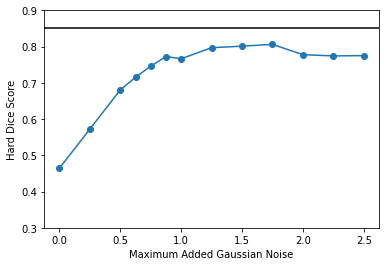

In [41]:
plt.plot(ld_range_results['rho'],ld_range_results['test_hard_dice'],marker='o')
plt.axhline(y=0.852,color='k')
plt.xlabel('Maximum Added Gaussian Noise')
plt.ylabel('Hard Dice Score')
plt.ylim([0.3,0.9])

Medium dosage dataset:

In [36]:
test_dataset, test_lbls = shuffle_Aug_PyTorch(img_md_dataset, label_md_dataset, 7427)
rho_list = [0.25, 0.5, 0.625, 0.75, 0.875, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5]
md_range_results = {'rho': [], 'test_loss': [], 'test_dice': [], 'test_hard_dice': []}
md_range_results['rho'].append(0)
md_range_results['test_hard_dice'].append(0.865177033636807)
md_range_results['test_loss'].append(0.121726199913929)
md_range_results['test_dice'].append(0.856245419425422)


In [37]:
for rho in rho_list:
    rho_name = str(rho).replace('.','p')
    model_filepath = 'Noise models/FF corrected 884/UNet_5nmAu330kX884eUTC_fold0_seed962_rhoMax'+rho_name+'_model.h5'
    model = torch.load(model_filepath)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    b_size = 32
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = 1e-4)
        
    # Run test set through model
    test_loss, test_dice, test_hard_dice = test_model(model, test_dataset, test_lbls, device, b_size, loss_fn, optimizer)
        
    # Record values
    md_range_results['rho'].append(rho)
    md_range_results['test_loss'].append(test_loss)
    md_range_results['test_dice'].append(test_dice)
    md_range_results['test_hard_dice'].append(test_hard_dice)

(0.5, 1.0)

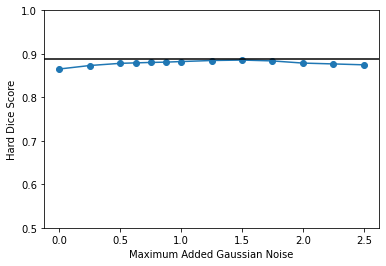

In [38]:
plt.plot(md_range_results['rho'],md_range_results['test_hard_dice'],marker='o')
plt.axhline(y=0.889,color='k')
plt.xlabel('Maximum Added Gaussian Noise')
plt.ylabel('Hard Dice Score')
plt.ylim([0.5,1.0])

And high dosage dataset:

In [32]:
test_dataset, test_lbls = shuffle_Aug_PyTorch(img_dataset, label_dataset, 7427)
rho_list = [0.25, 0.5, 0.625, 0.75, 0.875, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5]
hd_range_results = {'rho': [], 'test_loss': [], 'test_dice': [], 'test_hard_dice': []}
hd_range_results['rho'].append(0)
hd_range_results['test_hard_dice'].append(0.922700440561449)
hd_range_results['test_loss'].append(0.035549730666586)
hd_range_results['test_dice'].append(0.910678518785013)

In [33]:
for rho in rho_list:
    rho_name = str(rho).replace('.','p')
    model_filepath = 'Noise models/FF corrected 884/UNet_5nmAu330kX884eUTC_fold0_seed962_rhoMax'+rho_name+'_model.h5'
    model = torch.load(model_filepath)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    b_size = 32
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = 1e-4)
        
    # Run test set through model
    test_loss, test_dice, test_hard_dice = test_model(model, test_dataset, test_lbls, device, b_size, loss_fn, optimizer)
        
    # Record values
    hd_range_results['rho'].append(rho)
    hd_range_results['test_loss'].append(test_loss)
    hd_range_results['test_dice'].append(test_dice)
    hd_range_results['test_hard_dice'].append(test_hard_dice)

(0.3, 1.0)

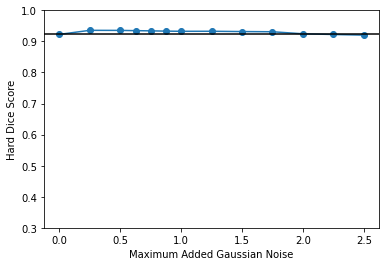

In [35]:
plt.plot(hd_range_results['rho'],hd_range_results['test_hard_dice'],marker='o')
plt.axhline(y=0.922700440561449, color='k')
plt.xlabel('Maximum Added Gaussian Noise')
plt.ylabel('Hard Dice Score')
plt.ylim([0.3,1.0])

And plotting the results all together:

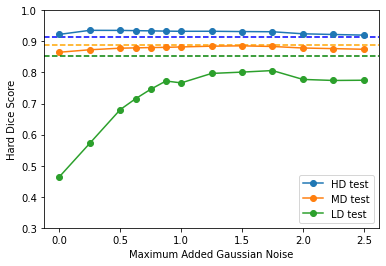

In [60]:
plt.axhline(y=0.915,color='b',linestyle='--')
plt.plot(hd_range_results['rho'],hd_range_results['test_hard_dice'], marker='o',label='HD test')
plt.axhline(y=0.889,color='orange',linestyle='--')
plt.plot(md_range_results['rho'],md_range_results['test_hard_dice'], marker='o',label='MD test')
plt.axhline(y=0.852,color='g',linestyle='--')
plt.plot(ld_range_results['rho'],ld_range_results['test_hard_dice'], marker='o',label='LD test')

plt.xlabel('Maximum Added Gaussian Noise')
plt.ylabel('Hard Dice Score')
plt.ylim([0.3,1.0])
plt.legend()
#plt.savefig('Figures/Paper/AugmentingHDNoise_MaxRho_250epoch_Lines.pdf')

# Understanding dataset statistics

First, let's visualize how our image changes upon additive Gaussian noise at various levels:

In [63]:
noise_0 = TEMImageDataset_Local_PartialRot(img_dataset,label_dataset, transform_flag = False)
noise_0p5 = TEMImageDataset_Local_PartialRot_Noise(img_dataset,label_dataset, transform_flag = False, noise_rho = 0.5)
noise_1 = TEMImageDataset_Local_PartialRot_Noise(img_dataset,label_dataset, transform_flag = False, noise_rho = 1)
noise_1p5 = TEMImageDataset_Local_PartialRot_Noise(img_dataset,label_dataset, transform_flag = False, noise_rho = 1.5)
noise_2 = TEMImageDataset_Local_PartialRot_Noise(img_dataset,label_dataset, transform_flag = False, noise_rho = 2)

In [89]:
torch.manual_seed(728679)

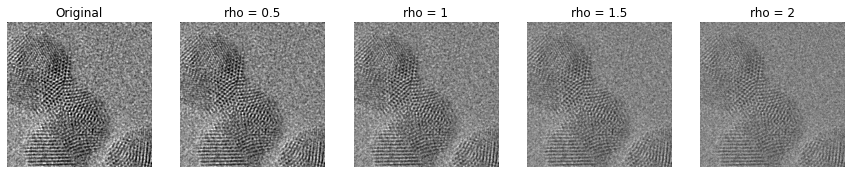

In [90]:
sample_num = 45
plt.figure(figsize=(15,4))
plt.subplot(1,5,1)
plt.imshow(noise_0[sample_num]['image'], vmin=-4, vmax=4, cmap='gray')
plt.axis('off')
plt.title('Original')
plt.subplot(1,5,2)
plt.imshow(np.squeeze(noise_0p5[sample_num]['image']), vmin=-4, vmax=4, cmap='gray')
plt.axis('off')
plt.title('rho = 0.5')
plt.subplot(1,5,3)
plt.imshow(np.squeeze(noise_1[sample_num]['image']), vmin=-4, vmax=4, cmap='gray')
plt.axis('off')
plt.title('rho = 1')
plt.subplot(1,5,4)
plt.imshow(np.squeeze(noise_1p5[sample_num]['image']), vmin=-4, vmax=4, cmap='gray')
plt.axis('off')
plt.title('rho = 1.5')
plt.subplot(1,5,5)
plt.imshow(np.squeeze(noise_2[sample_num]['image']), vmin=-4, vmax=4, cmap='gray')
plt.axis('off')
plt.title('rho = 2')
plt.savefig('Figures/Paper/AdditiveNoiseEx_Sample45.pdf')

Visually, it's most obvious that the nanoparticle contrast changes as we add more noise. We want to then understand whether the addive noise is enabling the augmented training set to better match the low dosage dataset. There are a variety of ways the two datasets can "match". We'll try to first see if the nanoparticle contrast values are similar, and try to quantify this by looking at the difference in median values of the nanoparticle vs background regions.

First, we'll calculate the "contrast" value of the low dosage dataset:

In [5]:
contrast_ld = np.median(img_ld_dataset[label_ld_dataset==0])-np.median(img_ld_dataset[label_ld_dataset==1])
print(contrast_ld)

0.23859542262911024


And then calculate the "contrast" value of the high dosage dataset, without any noise augmentation:

In [4]:
contrast_hd = np.median(img_dataset[label_dataset==0])-np.median(img_dataset[label_dataset==1])
print(contrast_hd)

0.5758098737650029


Then, we'll repeat this for all of the noise augmented datasets:

In [14]:
rho_list = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75,  0.875, 1,  1.125, 1.25, 1.5, 1.75, 2, 2.25, 2.5]
contrast_rho = [contrast_hd]

for rho in rho_list:
    if rho == 0:
        continue
    aug_imgs = (img_dataset+np.random.normal(loc=rho,size=(img_dataset.shape[0],512,512)))/np.sqrt(1+rho**2)
    contrast_aug = np.median(aug_imgs[label_dataset==0])-np.median(aug_imgs[label_dataset==1])
    contrast_rho.append(contrast_aug)

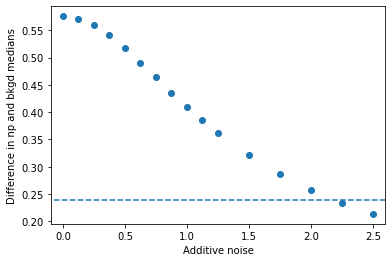

In [32]:
plt.scatter(rho_list,contrast_rho)
plt.hlines(contrast_ld,-0.2,2.7,linestyles='dashed')
plt.ylabel('Difference in np and bkgd medians')
plt.xlabel('Additive noise')
plt.xlim([-0.1,2.6])
#plt.savefig('Figures/Paper/SI/AdditiveNoise_NpContrast.eps')

Another way we can describe the dataset is through its noise statistics. However, we don't have the true noise-less versions of the images, so we cannot directly calculate their noise values. We can instead estimate the noise statistics, by calculating "image roughness", which quantifies how far information extends in Fourier space. 

In [38]:
def colin_img_roughness(img):
    # Code courtesy of Colin Ophus
    # Fourier coordinates or the sampling frequencies of the discrete FFT
    kx = np.fft.fftfreq(img.shape[0])
    ky = np.fft.fftfreq(img.shape[1])
    kr2 = kx[:,None]**2 + ky[None,:]**2
    
    # Get the FFT intensity
    G2 = np.abs(np.fft.fft2(img))**2
    
    #img roughness
    r2 = np.sum(G2*kr2)/np.sum(G2)
    
    return r2

In [39]:
def img_qual_dataset(dataset):
    img_qual = []
    for i in range(dataset.shape[0]):
        img_qual.append(colin_img_roughness(dataset[i,:,:]))
    return img_qual

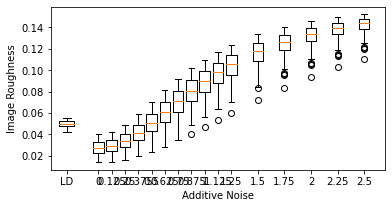

In [48]:
plt.figure(figsize=(6,3))
rho_list = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75,  0.875, 1,  1.125, 1.25, 1.5, 1.75, 2, 2.25, 2.5]
plt.boxplot([img_qual_dataset(img_ld_dataset)],positions=[-0.3],labels=['LD'])
for rho in rho_list:
    if rho == 0:
        plt.boxplot([img_qual_dataset(img_dataset)],positions=[rho],widths=0.1)
        continue
    aug_imgs = (img_dataset+np.random.normal(scale=rho,size=(img_dataset.shape[0],512,512)))/np.sqrt(1+rho**2)
    img_qual_aug = img_qual_dataset(aug_imgs)
    plt.boxplot([img_qual_aug],positions=[rho],widths=0.1)
plt.ylabel('Image Roughness')
plt.xlabel('Additive Noise')
plt.xlim([-0.45,2.7])
#plt.savefig('Figures/Paper/SI/AdditiveNoise_ImgRoughnessMatching.eps')